Carregando os dados...
Colunas do DataFrame após o processamento: ['v1', 'v2', 'y']
Treinando a Rede Neural PMC...

--- Resultados da Avaliação (Dados de Teste) ---
Erro Quadrático Médio (MSE): 0.0129
Erro Absoluto Médio (MAE): 0.0753 polegadas
Coeficiente de Determinação (R²): 0.9845


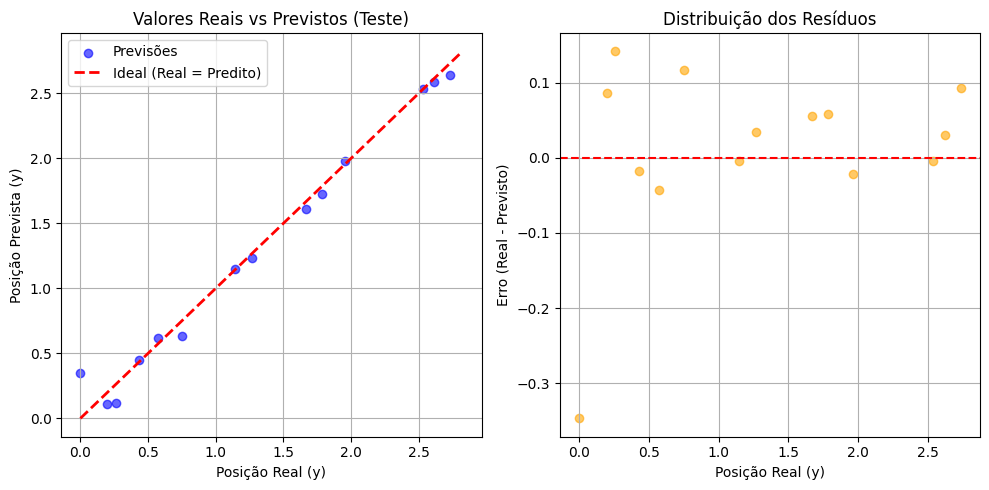

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Carregamento dos Dados
# Lembre-se de fazer o upload do 'LDR_ball.xlsx' no ambiente do Colab
print("Carregando os dados...")
try:
    # Carrega o arquivo sem cabeçalho para ter controle total sobre as colunas
    df_raw = pd.read_excel('LDR_ball.xlsx', header=None)

    # A primeira coluna contém os nomes das variáveis e o restante são os dados
    # A estrutura observada é que as variáveis (v1, v2, y) estão nas linhas e os pontos de dados nas colunas.
    # Vamos transpor o DataFrame para que as variáveis se tornem colunas.

    # 1. Usa a primeira coluna como índice
    df_indexed = df_raw.set_index(0)

    # 2. Transpõe o DataFrame para que as variáveis sejam as colunas
    df = df_indexed.T

    # 3. Convertendo os nomes das colunas para string antes de aplicar replace para evitar erros
    df.columns = df.columns.astype(str).str.replace(r'\(V\)', '', regex=True).str.replace(r'\(pol\)', '', regex=True).str.strip()

    # 4. Seleciona apenas as colunas relevantes ('v1', 'v2', 'y') e descarta as colunas extras com 'nan'
    df = df[['v1', 'v2', 'y']]

    # 5. Converte todas as colunas para tipo numérico
    # 'errors='coerce'' substituirá valores não numéricos por NaN
    df = df.apply(pd.to_numeric, errors='coerce')

    # 6. Remove quaisquer linhas que possam ter NaN após a conversão (agora focado apenas nas colunas relevantes)
    df = df.dropna()

    # Verificando as colunas resultantes
    print(f"Colunas do DataFrame após o processamento: {df.columns.tolist()}")

except FileNotFoundError:
    raise Exception("Arquivo 'LDR_ball.xlsx' não encontrado! Faça o upload no Colab.")
except Exception as e:
    raise Exception(f"Erro ao carregar ou processar o arquivo Excel: {e}")

# 1. Assumindo que as colunas se chamem 'v1', 'v2' (entradas) e 'y' (saída)
X = df[['v1', 'v2']] # Variáveis de entrada (Tensões)
y = df['y']          # Variável de saída (Posição em polegadas)

# 2. Divisão em Treino e Teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Pré-processamento: Padronização dos dados (Crucial para Redes Neurais)
# Redes neurais são sensíveis à escala dos dados.
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# 4. Criação e Treinamento do Modelo PMC (MLPRegressor)
# PREZANDO PELA PARCIMÔNIA: Usaremos apenas 1 camada oculta com poucos neurônios (ex: 5 neurônios).
mlp = MLPRegressor(
    hidden_layer_sizes=(5,),       # 1 camada oculta com 5 neurônios
    activation='relu',             # Função de ativação
    solver='lbfgs',                # 'lbfgs' costuma ser melhor e mais rápido para datasets pequenos
    max_iter=2000,                 # Número máximo de épocas
    random_state=42                # Semente para reprodutibilidade
)

print("Treinando a Rede Neural PMC...")
mlp.fit(X_train_scaled, y_train)

# 5. Previsões e Avaliação
y_pred_train = mlp.predict(X_train_scaled)
y_pred_test = mlp.predict(X_test_scaled)

# Cálculo de Métricas (MSE, MAE, R²)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n--- Resultados da Avaliação (Dados de Teste) ---")
print(f"Erro Quadrático Médio (MSE): {mse_test:.4f}")
print(f"Erro Absoluto Médio (MAE): {mae_test:.4f} polegadas")
print(f"Coeficiente de Determinação (R²): {r2_test:.4f}")

# 6. Visualização dos Resultados
plt.figure(figsize=(10, 5))

# Gráfico 1: Valores Reais vs Preditos no Teste
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, color='blue', alpha=0.6, label='Previsões')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal (Real = Predito)')
plt.title('Valores Reais vs Previstos (Teste)')
plt.xlabel('Posição Real (y)')
plt.ylabel('Posição Prevista (y)')
plt.legend()
plt.grid(True)

# Gráfico 2: Erro residual
residuos = y_test - y_pred_test
plt.subplot(1, 2, 2)
plt.scatter(y_test, residuos, color='orange', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Distribuição dos Resíduos')
plt.xlabel('Posição Real (y)')
plt.ylabel('Erro (Real - Previsto)')
plt.grid(True)

plt.tight_layout()
plt.show()